In [1]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
#define cosmo
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [1]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count
import CL_COUNT_modeling_richness as richness_model

# Define proxy modelling
Use a mass proxy, define the probability for observing a proxy given a mass and redhsift

$$
P(\log\lambda|M,z) = N(\mu(M,z), \sigma^2(M,z))
$$
the mean is
$$
\mu(M,z) = \mu_0 + a_\mu^M\log_{10}\frac{M}{M_0} + a_M^z\log_{10}\frac{1+z}{1+z_0} 
$$
variance is
$$
\sigma(M,z) = \sigma_0 + a_\sigma^M\log_{10}\frac{M}{M_0} + a_\sigma ^z\log_{10}\frac{1+z}{1+z_0} 
$$

In [3]:
#M_0, z_0
theta_pivot = [3e14/0.71, 0.6]
#\mu_0, a_\mu^z, a_\mu^M
theta_mu = [3.19, -0.7, 2]
#\sigma_0, a_\sigma^z, a_\sigma^M
theta_sigma = [0.33, 0.,-0.08]
#Richness object
richness = richness_model.Richness(theta_mu, theta_sigma, theta_pivot)

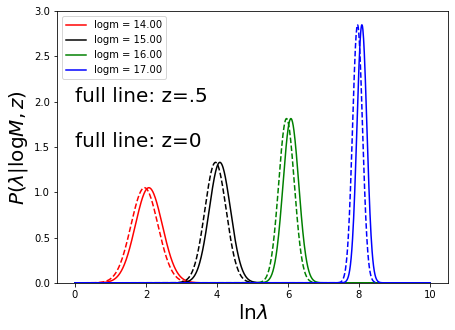

In [4]:
plt.figure(figsize = (7,5))
proxy_array = np.linspace(0,10,1000)
logm_array = np.linspace(14, 17, 4)
c = ['r', 'k', 'g', 'b']
for i, logm_ in enumerate(logm_array):
    p = richness.pdf(proxy_array, .0, logm_)
    plt.plot(proxy_array, p, label=f'logm = {logm_:.2f}', c = c[i])
    p = richness.pdf(proxy_array, .5, logm_,)
    plt.plot(proxy_array, p, '--', c = c[i])
plt.ylabel(r'$P(\lambda|\log M, z)$', fontsize = 20)
plt.ylim(0,3)
plt.legend()
plt.xlabel('$\ln \lambda$', fontsize = 20)
plt.text(0, 1.5,'full line: z=0', fontsize = 20)
plt.text(0, 2,'full line: z=.5', fontsize = 20)
plt.show()

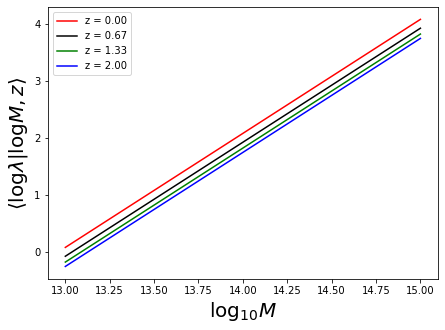

In [5]:
plt.figure(figsize = (7,5))
z_array = np.linspace(0,2,4)
logm_array = np.linspace(13, 15, 300)
c = ['r', 'k', 'g', 'b']
for i, z in enumerate(z_array):
    p = richness.mu_loglambda_logM_f(z, logm_array)
    plt.plot(logm_array, p, label=f'z = {z:.2f}', c = c[i])
plt.ylabel(r'$\langle\log\lambda|\log M, z\rangle$', fontsize = 20)
plt.legend()
plt.xlabel('$\log_{10}M$', fontsize = 20)
plt.show()

initialize the `ClusterAbundance` object

In [6]:
clc = cl_count.ClusterAbundance()
#choose mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Un-binned approach

$$
x_i = \int_{\log_{10}M_{min}}^{\log_{10}M_{min}}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M,z_i)}{d\log_{10}M}P(\lambda_i|M,z_i)d\log_{10}M
$$

In [7]:
import random
n = 100
z_list = np.linspace(0.1,2,n)
random.shuffle(z_list)
proxy_list = np.linspace(1,4,n)

pre tabulated grids to fasten integration

In [8]:
z_grid = np.linspace(0., 3, 1000)
logm_grid = np.linspace(12,16, 1000)
clc.compute_pdf_grid_ProxyZ(proxy = proxy_list, z = z_list, proxy_model = richness, 
                            z_grid = z_grid, logm_grid = logm_grid)

Three different methods:
1. Simpson integration of a tabulated grid of $\frac{d^2V}{dz d\Omega}\frac{dn}{d\log_{10}M}P(\lambda|M,z)$ (method `grid`)
2. Double integral using `scipy.integrate.dblquad` of $\frac{d^2V}{dz d\Omega}\frac{dn}{d\log_{10}M}P(\lambda|M,z)$ (method `exact`)

`grid`

In [9]:
time0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
dndproxy_grid = clc.multiplicity_function_individual_ProxyZ(z = z_list, proxy = proxy_list, 
                                                             proxy_model = richness, method = 'grid')
time1 = time.time()
print(time1-time0)

0.8316056728363037


`exact`

In [10]:
time0 = time.time()
dndproxy_exact = clc.multiplicity_function_individual_ProxyZ(z = z_list, proxy = proxy_list, 
                                                                 proxy_model = richness, method = 'exact')
time1 = time.time()
print(time1-time0)

20.96118927001953


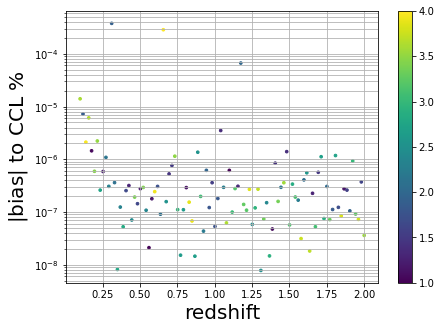

In [11]:
plt.figure(figsize = (7,5))
plt.scatter(z_list, 100*abs(np.array(dndproxy_exact)-np.array(dndproxy_grid))/np.array(dndproxy_exact), s = 7, c = proxy_list, cmap = 'viridis')
plt.colorbar()
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('|bias| to CCL $\%$', fontsize = 20)
plt.yscale('log')
plt.grid(True, which="both")

In [12]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count
import CL_COUNT_modeling_richness as richness_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
clc = cl_count.ClusterAbundance()
#choose mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach

Comptue the integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}P(\lambda|M,z)d\log_{10}M
$$

define binning

In [14]:
z_edges = np.linspace(0.25, 1, 10)
proxy_edges = np.linspace(0, 2, 2)

pre tabulated grid (only depends on mass-proxy relation)

In [15]:
clc.compute_cumulative_grid_ProxyZ(proxybin_edges = proxy_edges, proxy_model = richness, 
                                   z_grid = z_grid, logm_grid = logm_grid)

Three different methods to integrate
$$
\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}\int_{\lambda_{\rm bin}}P(\lambda|M,z)d\lambda
$$
1. 2D Simpson integration on M-z axis on a fixed grid (method `grid`)
2. Double integral using `scipy.integrate.dblquad` over a interpolated function based on a tabulated grid (method `interp`)
3. "Exact" double integral using direclty `scipy.integrate.dblquad` on the integrand (method `exact`)

`grid`

In [16]:
time0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
N_ProxyZ_grid = clc.Cluster_Abundance_ProxyZ(zbin_edges = z_edges, proxybin_edges = proxy_edges, 
                                              logm_limit = [min(logm_grid), max(logm_grid)], 
                                 proxy_model = richness, method = 'grid')
time1 = time.time()
print('time (seconds) = ' + str(time1-time0))

time (seconds) = 0.7069299221038818


In [17]:
N_ProxyZ_grid

array([[275054.20786298],
       [396067.56314932],
       [512113.20607191],
       [614968.94548312],
       [699479.18978593],
       [763916.0926769 ],
       [807237.80634024],
       [829464.44210314],
       [832481.23482863]])

`interp`

In [18]:
time0 = time.time()
N_ProxyZ_interp = clc.Cluster_Abundance_ProxyZ(zbin_edges = z_edges, proxybin_edges = proxy_edges,
                                                       logm_limit = [min(logm_grid), max(logm_grid)], 
                                 proxy_model = richness, method = 'interp')
time1 = time.time()
print('time (seconds) = ' + str(time1-time0))

time (seconds) = 33.579933881759644


`exact`

In [ ]:
time0 = time.time()
N_ProxyZ_exact = clc.Cluster_Abundance_ProxyZ(zbin_edges = z_edges, proxybin_edges = proxy_edges,
                                                  logm_limit = [min(logm_grid), max(logm_grid)], 
                                 proxy_model = richness, method = 'exact')
time1 = time.time()
print('time (seconds) = ' + str(time1-time0))

In [ ]:
plt.figure(figsize = (7,5))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
proxy = [np.mean([proxy_edges[i],proxy_edges[i+1]]) for i in np.arange(len(proxy_edges)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(proxy_edges)-1):
    label = [None, None]
    if f == 0:
        label = ['grid', 'interp']
    y_grid = abs(100. * (1. - N_ProxyZ_grid[:,f] / N_ProxyZ_exact[:,f]))
    y_interp = abs(100. * (1. - N_ProxyZ_interp[:,f] / N_ProxyZ_exact[:,f]))
    plt.scatter(z_, y_grid, color = 'k', label = label[0])
    plt.scatter(z_, y_interp, color = 'r', label = label[1])
plt.grid(True, which="both" )
plt.ylabel(r'|biais| to exact $(\%)$', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)